In [1]:
import sys
import os

sys.path.append('/Users/raphaelravinet/Code')
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from algo_trading.log_config import setup_logging
from Fin_Database.Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from algo_trading.Pre_Processing.pre_processing import PreProcessing
from algo_trading.Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [2]:
tickers = ['AAPL', 'MSFT', 'SPY']

In [3]:
pipe = Pipeline(tickers)

In [4]:
minute_data = pipe.pipeline(timespan='minute',start_date='2018-01-01',end_date='2019-01-01')
hourly_data = pipe.pipeline(timespan='hour',start_date='2018-01-01',end_date='2019-01-01')
daily_data = pipe.pipeline(timespan='daily',start_date='2018-01-01',end_date='2019-01-01')


In [31]:
minute_data['AAPL']

,id,date,timestamp,ticker,open,high,low,close,volume,vwap,...,ema_50,sma_100,ema_100,sma_200,ema_200,sma_300,ema_300,day,month,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 09:30:00,3537981,2018-01-02 09:30:00,1514903400000,AAPL,42.5400,42.5550,42.4675,42.4850,2930684.0,42.5213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
2018-01-02 09:31:00,3537982,2018-01-02 09:31:00,1514903460000,AAPL,42.4851,42.5141,42.4150,42.4200,757016.0,42.4469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
2018-01-02 09:32:00,3537983,2018-01-02 09:32:00,1514903520000,AAPL,42.4175,42.4725,42.3875,42.3900,821684.0,42.4385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
2018-01-02 09:33:00,3537984,2018-01-02 09:33:00,1514903580000,AAPL,42.3900,42.3900,42.3150,42.3500,888532.0,42.3379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
2018-01-02 09:34:00,3537985,2018-01-02 09:34:00,1514903640000,AAPL,42.3600,42.4125,42.3563,42.4125,803392.0,42.3764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 15:56:00,3703681,2018-12-31 15:56:00,1546289760000,AAPL,39.3025,39.3025,39.1200,39.1775,1680212.0,39.2205,...,39.309190,39.325667,39.336908,39.426434,39.371996,39.428050,39.370141,31,12,0
2018-12-31 15:57:00,3703682,2018-12-31 15:57:00,1546289820000,AAPL,39.1750,39.2125,39.1475,39.1850,586404.0,39.1836,...,39.304320,39.323567,39.333900,39.423884,39.370135,39.428066,39.368911,31,12,0
2018-12-31 15:58:00,3703683,2018-12-31 15:58:00,1546289880000,AAPL,39.1825,39.2000,39.1575,39.1750,715304.0,39.1818,...,39.299248,39.320979,39.330754,39.421261,39.368193,39.427975,39.367622,31,12,0


#### Applying the Approach from Young Li's Paper: 
**"A Practical Model for Prediction of Intraday Volatility"**

**Potential Improvement:**

1. **Change the daily vol model from EWMA to a GARCH-type model**


In [10]:
# class IntraBarsProfile:
#     def __init__(self, hf_df, lf_df, daily_df, timespan):
#         """args:
#         hf_df: higher frequency dataframe
#         lf_df: lower frequency dataframe
#         daily_df: daily dataframe
#         timespan: timespan of the lower frequency data to aggregate : '15M', '1H', '1D', '1W....'"""
#         self.hf_df = hf_df
#         self.lf_df = lf_df
#         self.daily_df = daily_df
#         self.timespan = timespan
        
        

In [32]:
import pandas as pd

# Create a simple dummy dataset with datetime index
data = {
    'open': [100, 102, 101, 103, 102, 104],
    'high': [103, 104, 105, 106, 107, 108],
    'low': [99, 100, 99, 101, 101, 102],
    'close': [102, 103, 104, 105, 106, 107],
}

times = pd.date_range('2023-09-02 09:00', periods=6, freq='30T')
df = pd.DataFrame(data, index=times)

print("Original DataFrame:")
print(df)

# Floor the times to nearest 30 mins
df_grouped = df.groupby(df.index.floor('30T')).aggregate({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})

print("\nGrouped DataFrame (flooring):")
print(df_grouped)

# Now let's test using ceil instead of floor
df_grouped_ceil = df.groupby(df.index.ceil('30T')).aggregate({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})

print("\nGrouped DataFrame (ceiling):")
print(df_grouped_ceil)


Original DataFrame:
                     open  high  low  close
2023-09-02 09:00:00   100   103   99    102
2023-09-02 09:30:00   102   104  100    103
2023-09-02 10:00:00   101   105   99    104
2023-09-02 10:30:00   103   106  101    105
2023-09-02 11:00:00   102   107  101    106
2023-09-02 11:30:00   104   108  102    107

Grouped DataFrame (flooring):
                     open  high  low  close
2023-09-02 09:00:00   100   103   99    102
2023-09-02 09:30:00   102   104  100    103
2023-09-02 10:00:00   101   105   99    104
2023-09-02 10:30:00   103   106  101    105
2023-09-02 11:00:00   102   107  101    106
2023-09-02 11:30:00   104   108  102    107

Grouped DataFrame (ceiling):
                     open  high  low  close
2023-09-02 09:00:00   100   103   99    102
2023-09-02 09:30:00   102   104  100    103
2023-09-02 10:00:00   101   105   99    104
2023-09-02 10:30:00   103   106  101    105
2023-09-02 11:00:00   102   107  101    106
2023-09-02 11:30:00   104   108  102   

In [140]:
class IntradayVol:
    def __init__(self, hf_df, lf_df, daily_df, timespan, decay_factor = 0.94):
        """args:
        hf_df: higher frequency dataframe
        lf_df: lower frequency dataframe
        daily_df: daily dataframe
        timespan: timespan of the lower frequency data to aggregate : '15M', '1H', '1D', '1W....'"""
        self.hf_df = hf_df
        self.lf_df = lf_df
        self.daily_df = daily_df
        self.timespan = timespan
        self.decay_factor = decay_factor

    
    def ewma_vol(self):
        """ Calculate daily vol using EWMA model """
        self.daily_df['daily_vol_squared'] = np.zeros(len(self.daily_df), dtype=float)
        
        self.daily_df['squared_log_ret'] = self.daily_df['log_ret'] ** 2
        self.daily_df['squared_log_ret'].bfill(inplace=True)

        for i in range(1, len(self.daily_df)):
            self.daily_df.loc[self.daily_df.index[i], 'daily_vol_squared'] = (
                self.decay_factor * self.daily_df['daily_vol_squared'].iloc[i-1] +
                (1 - self.decay_factor) * self.daily_df['squared_log_ret'].iloc[i]
            )
        
        return np.sqrt(self.daily_df['daily_vol_squared'])
    
    
    def garch_vol(self):
        """ Calculate daily vol using GARCH(1,1) model """
        self.daily_df.dropna(subset=['return'], inplace=True)
        
        model = arch_model(self.daily_df['return'] * 100, vol='EGARCH', p=1, q=1)
        garch_results = model.fit(disp="off")
        
        # Extract the conditional volatility from the model
        self.daily_df['daily_vol'] = garch_results.conditional_volatility / 100  # scale back down
        
        return self.daily_df['daily_vol']


    
    def calculate_diurnal_profile(self):
        """Calculate diurnal profile. Basically the average of the Garman-Klass vol for each time of the day. 
        It is calculated using the aggregated data of the higher frequency data"""
        #removing the first datapoint of the day, as it is not a full interval
        self.hf_df = self.hf_df[self.hf_df.index.time != pd.Timestamp("09:30:00").time()]

        aggregated_df = self.hf_df.groupby(self.hf_df.index.ceil(self.timespan)).aggregate({'open': 'first', 
                                                               'high': 'max', 
                                                               'low': 'min', 
                                                               'close': 'last'})
        
        
        garma_klass_vol = np.sqrt(0.5*(np.log(aggregated_df['high']) - np.log(aggregated_df['low']))**2 - (2 * np.log(2) -1) * (np.log(aggregated_df['close']) - np.log(aggregated_df['open']))**2)
        q5 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.05)
        q25 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.25)
        q50 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.5)
        q75 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.75)
        q95 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.95)
        
        diurnal_profile = (q25 + q50 + q75) / 3
        diurnal_profile = diurnal_profile / diurnal_profile.mean()
        
        return diurnal_profile, q5, q25, q50, q75, q95
    
    
    
    def predict_vol(self):
        """ Predict vol for the next time interval"""
        daily_vol = self.ewma_vol().shift(1)
        diurnal_profile = self.calculate_diurnal_profile()
        avg_diurnal_profile = diurnal_profile.mean()
        
        # time-scaling factor (rho_t)
        time_scaling_factor = 1  

        self.lf_df['vol_forecasts'] = np.nan
        for i in range(len(self.lf_df)):
            current_time = self.lf_df.index[i].time()
            current_date = self.lf_df.index[i].date()
            
            daily_vol_value = daily_vol.loc[pd.Timestamp(current_date)]
            if current_time in diurnal_profile.index:
                self.lf_df.loc[self.lf_df.index[i], 'vol_forecasts'] = (
                    daily_vol_value * time_scaling_factor * (diurnal_profile[current_time] / avg_diurnal_profile)
                )
            else:
                self.lf_df.loc[self.lf_df.index[i], 'vol_forecasts'] = np.nan
        return self.lf_df


In [141]:
intraday_vol_aapl = IntradayVol(hf_df=minute_data['AAPL'], lf_df=hourly_data['AAPL'], daily_df=daily_data['AAPL'], timespan='30T')

In [142]:
intraday_vol_msft = IntradayVol(hf_df=minute_data['MSFT'], lf_df=hourly_data['MSFT'], daily_df=daily_data['MSFT'], timespan='30T')

In [157]:
def plot_diurnal_profile(diurnal_profile, q5, q25, q50, q75, q95):
    """Plot the diurnal profile with specified intervals on the x-axis."""

    times = sorted(diurnal_profile.index.unique())
    
    times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]

    plt.figure(figsize=(12, 6))
    
    plt.plot(times_as_datetime, q50, label="Median (50th percentile)", color='blue')
    
    # Filling the area between the 5th and 95th percentiles and 25th and 75th percentiles
    plt.fill_between(times_as_datetime, q5, q95, color='red', alpha=0.3, label="5th to 95th percentile")
    plt.fill_between(times_as_datetime, q25, q75, color='green', alpha=0.3, label="25th to 75th percentile")
    
    # Set the x-axis labels as our interval times
    plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
    
    # Titles and labels
    plt.title("Diurnal Profile of Garman-Klass Volatility")
    plt.xlabel("Time of Day")
    plt.ylabel("Normalized Volatility")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [158]:
diurnal_profile, q5, q25, q50, q75, q95 = intraday_vol_aapl.calculate_diurnal_profile()


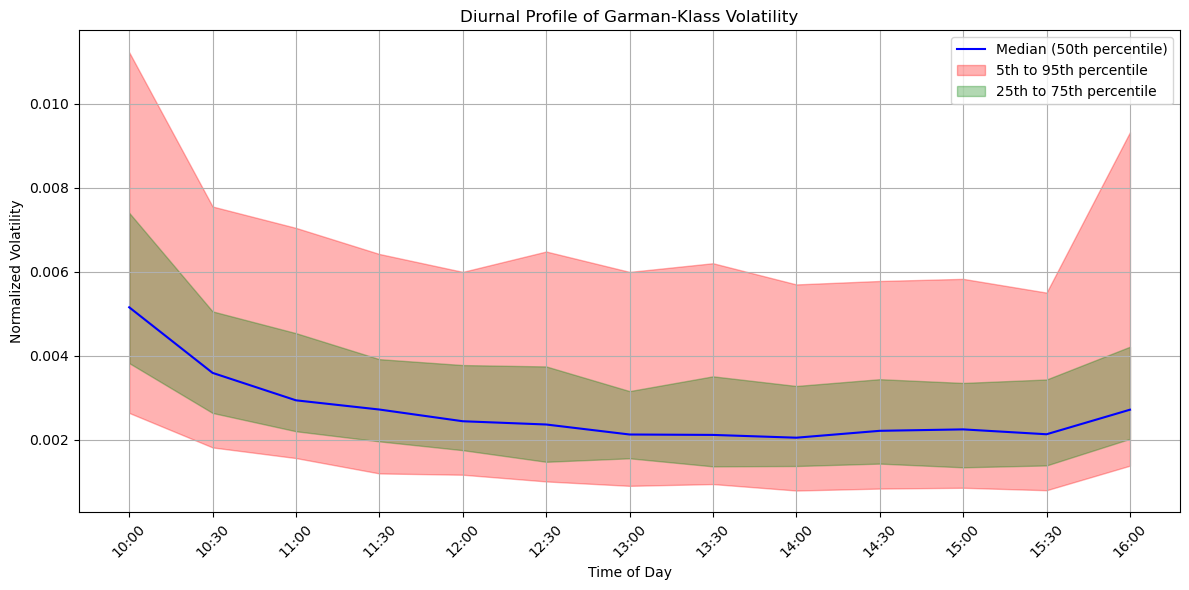

In [159]:
plot_diurnal_profile(diurnal_profile,q5, q25, q50, q75, q95)

In [ ]:
plt.plot(aapl_daily['garch'], label='GARCH')
plt.plot(aapl_daily['true_vol'], label='true')

In [ ]:
aapl_minute = minute_data['AAPL']

In [ ]:
aapl_aggregate = aapl_minute.groupby(aapl_minute.index.floor('5T')).aggregate({'open': 'first', 
                                                               'high': 'max', 
                                                               'low': 'min', 
                                                               'close': 'last'})

In [ ]:
aapl_aggregate['log_ret'] = np.log(aapl_aggregate['close']).diff()

In [ ]:
aapl_daily

In [ ]:
from arch import arch_model

In [ ]:
aapl_daily['log_ret_scaled'] = aapl_daily['log_ret'] * 100

In [ ]:
plt.plot(aapl_daily['true_vol'], label='True Vol')
plt.plot(aapl_daily['ewma_vol'], label='ewma Forecasted Vol')

In [ ]:
aapl_daily['true_vol'] = aapl_aggregate.groupby(aapl_aggregate.index.date).aggregate({'log_ret': 'sum'})

In [ ]:
timespan = '1H' 
aapl_vol_model = IntradayVol(hf_df=aapl_min, lf_df=aapl_hourly, daily_df=aapl_daily, timespan=timespan)
msft_vol_model = IntradayVol(hf_df=msft_min, lf_df=msft_hourly, daily_df=msft_daily, timespan=timespan)

In [ ]:
# AAPL Volatility Calculations
aapl_daily_vol = aapl_vol_model.calculate_daily_vol()
aapl_diurnal_profile = aapl_vol_model.calculate_diurnal_profile()
aapl_predicted_vol = aapl_vol_model.predict_vol()

# MSFT Volatility Calculations
msft_daily_vol = msft_vol_model.calculate_daily_vol()
msft_diurnal_profile = msft_vol_model.calculate_diurnal_profile()
msft_predicted_vol = msft_vol_model.predict_vol()


In [ ]:
#Using the Garma Klass vol formula as target
aapl_predicted_vol['target'] = (np.sqrt(0.5 * (np.log(aapl_predicted_vol['high']) - np.log(aapl_predicted_vol['low']))**2 -
                              (2 * np.log(2) - 1) * (np.log(aapl_predicted_vol['close']) - np.log(aapl_predicted_vol['open']))**2)).shift(-1)

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(aapl_predicted_vol['vol_forecasts'], label='Forecasted Volatility')
plt.plot(aapl_predicted_vol['target'], label='Target Volatility')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(aapl_predicted_vol['vol_forecasts'], label='Forecasted Volatility')
plt.plot(np.abs(aapl_predicted_vol['log_ret']), label='Abs Log Ret')
plt.show()

In [ ]:
aapl_predicted_vol2 = aapl_predicted_vol.iloc[15:-1].copy()

In [ ]:
rmse(aapl_predicted_vol2['vol_forecasts'], aapl_predicted_vol2['target'])